# King County Housing with Multiple Linear Regression
### Authors: Diane Tunnicliffe, Dana Rausch, Matthew Lipman

## Notebook 3: Models and Evaluations

This notebook contains linear regression models for our raw, cleaned, and transformed data. We attempted many variations of our model and improved upon them with each iteration to find the best fit for our data. This notebook includes the ten iterations of the model, along with the steps taken to improve them, as well as exploration of necessary assumptions and outputs. The models are evluated sequentially and culminate in a final evaluation and conclusion.

In [1]:
# importing the packages we will be using for this project
import pandas as pd
# setting pandas display to avoid scientific notation in my dataframes
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from bs4 import BeautifulSoup
import json
import requests

import folium

import haversine as hs 

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import scipy.stats as stats

import pylab

%matplotlib inline

## Model #1  
Our first model takes the original raw data and features, within one standard deviation of the mean for price.

In [2]:
df = pd.read_csv('./data/all_features_with_logs.csv', index_col=0)

In [4]:
# define features and target
features = ['sqft_living', 'closest_distance_to_top_school', 'min_dist_park', 'closest_distance_to_great_coffee', 'closest_distance_to_scientology']
target = ['price']

# separate dataframe into feature matrix x and target vector y
X = df[features]
y = df[target]

# now we can instantiate our linear regression estimator and fit our data
lm1 = LinearRegression()
lm1.fit(X, y)

lm1_preds = lm1.predict(X)

print('R^2: ', r2_score(y, lm1_preds))

R^2:  0.535898617659569


In [471]:
formula = "price ~ sqft_living+closest_distance_to_top_school+min_dist_park+closest_distance_to_great_coffee+closest_distance_to_scientology"
model = ols(formula= formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     3810.
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:37:42   Log-Likelihood:            -2.1650e+05
No. Observations:               16493   AIC:                         4.330e+05
Df Residuals:                   16487   BIC:                         4.330e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         2.683e+05   3929.931     68.270      0.000    2.61e+05    2.76e+05
sqft_living                        153.6182      1.372    111.950      0.000     150.928     156.308
closest_distance_to_top_school   -1.022e+04    302.440    -33.785      0.000   -1.08e+04   -9625.052
min_dist_park                     -173.1658    468.670     -0.369      0.712   -1091.809     745.477
closest_distance_to_great_coffee   560.4484    186.671      3.002      0.003     194.554     926.343
closest_distance_to_scientology  -4317.5897    115.198    -37.480      0.000   -4543.391   -4091.789
==============================================================================
Omnibus:                      367.787   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              408.256
Skew:                           0.341   Prob(JB):                     2.23e-89
Kurtosis:                       3.358   Cond. No.                     8.52e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

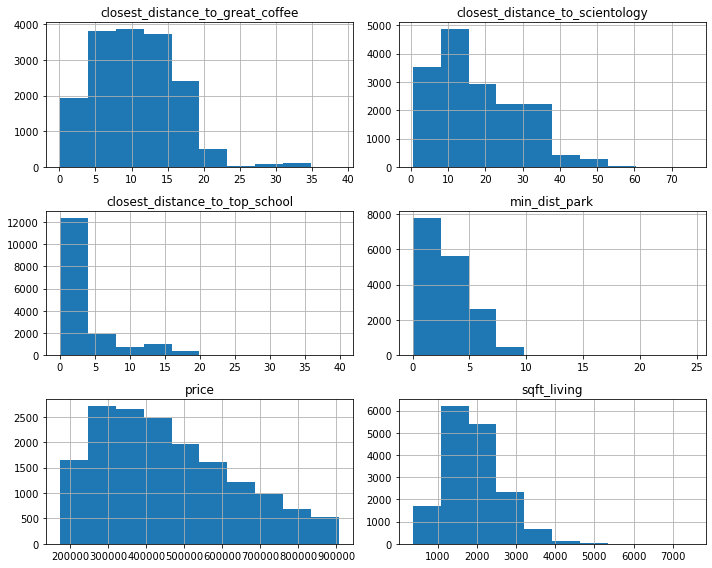

In [472]:
# checking the visual distribution of our data with histograms
df[['sqft_living', 'closest_distance_to_great_coffee', 'min_dist_park', 'closest_distance_to_top_school', 'closest_distance_to_scientology', 'price']].hist(figsize=(10,8))
plt.tight_layout();

Our distributions for our features were not normal. Please see previous notebook for full investigation of this, analysis of skew and kurtosis, and decision-making regarding transformations.

## Model #2  

We performed a log-transformation for some of our features to see if this helped to achieve a more normal distribution and improve our model. (For actual process of log-transforming, and visualizations of each feature before and after log-transformation, please see previous notebook titled 'data_wrangling'.)

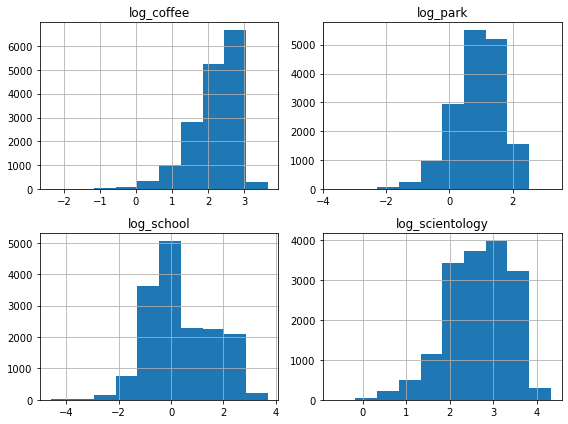

In [473]:
# displaying the visual distribution of our log-transformed data with histograms
df[['log_coffee', 'log_park', 'log_school', 'log_scientology']].hist(figsize=(8,6))
plt.tight_layout();

For the full visualizations (sns.distplot) of each feature before and after log-transformation, please see previous notebook ('data_wrangling.ipynb'). 

In [474]:
features = ['sqft_living', 'log_school', 'log_park', 'log_scientology', 'log_coffee']
target = ['price']

X = df[features]
y = df[target]

lm2 = LinearRegression().fit(X, y)

lm2_preds = lm2.predict(X)

print('R^2: ', r2_score(y, lm2_preds))

R^2:  0.5682736472606391


In [475]:
formula = "price ~ sqft_living+log_school+log_park+log_scientology+log_coffee"
model = ols(formula= formula, data=df).fit()

In [476]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     4340.
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:37:44   Log-Likelihood:            -2.1590e+05
No. Observations:               16493   AIC:                         4.318e+05
Df Residuals:                   16487   BIC:                         4.319e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.149e+05   6428.255     64.540      0.000    4.02e+05    4.27e+05
sqft_living       157.8594      1.318    119.806      0.000     155.277     160.442
log_school      -3.735e+04    960.198    -38.902      0.000   -3.92e+04   -3.55e+04
log_park         -502.9330   1215.674     -0.414      0.679   -2885.785    1879.919
log_scientology -7.418e+04   1707.144    -43.453      0.000   -7.75e+04   -7.08e+04
log_coffee      -2.206e+04   1447.451    -15.242      0.000   -2.49e+04   -1.92e+04
==============================================================================
Omnibus:                      343.757   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              428.348
Skew:                           0.284   Prob(JB):                     9.67e-94
Kurtosis:                       3.548   Cond. No.                     1.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

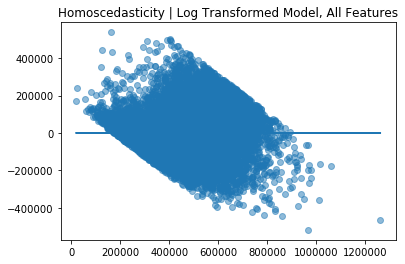

In [477]:
predictors_log = ['sqft_living', 'log_school', 'log_scientology', 'log_coffee', 'log_park']

plt.scatter(model.predict(df[predictors_log]), model.resid, alpha = .5);
plt.plot(model.predict(df[predictors_log]), [0 for i in range(len(df))]);
plt.title('Homoscedasticity | Log Transformed Model, All Features');

The variability of price is not equal at all; this model is heteroscedastic. While this iteration increased our R2 score some, we still hoped to achieve a higher one.

## Model #3  

To attempt to increase our R2 score, we then tried removing certain features to see if the score increased.

In [478]:
df.corr()

,price,sqft_living,grade,lat,long,min_dist_park,closest_distance_to_top_school,closest_distance_to_great_coffee,closest_distance_to_scientology,log_school,log_coffee,log_scientology,log_park
price,1.00,0.56,0.57,0.45,0.07,0.01,-0.42,-0.18,-0.34,-0.41,-0.14,-0.33,0.01
sqft_living,0.56,1.00,0.68,-0.02,0.27,0.01,0.02,-0.13,0.17,0.08,-0.12,0.20,0.02
grade,0.57,0.68,1.00,0.05,0.25,0.01,-0.03,-0.13,0.11,0.01,-0.11,0.13,0.02
lat,0.45,-0.02,0.05,1.00,-0.13,0.01,-0.68,-0.15,-0.73,-0.63,-0.07,-0.63,0.00
long,0.07,0.27,0.25,-0.13,1.00,-0.01,0.01,-0.37,0.63,0.13,-0.43,0.62,-0.01
min_dist_park,0.01,0.01,0.01,0.01,-0.01,1.00,0.01,0.02,-0.01,0.00,0.02,-0.00,0.90
closest_distance_to_top_school,-0.42,0.02,-0.03,-0.68,0.01,0.01,1.00,0.34,0.66,0.86,0.24,0.57,0.01
closest_distance_to_great_coffee,-0.18,-0.13,-0.13,-0.15,-0.37,0.02,0.34,1.00,0.12,0.16,0.92,-0.05,0.02
closest_distance_to_scientology,-0.34,0.17,0.11,-0.73,0.63,-0.01,0.66,0.12,1.00,0.66,-0.02,0.93,-0.00
log_school,-0.41,0.08,0.01,-0.63,0.13,0.00,0.86,0.16,0.66,1.00,0.10,0.63,0.00


Distance to parks seemed to have a relatively low correlation with price, so we experimented with removing that first.

In [479]:
features = ['sqft_living', 'log_school', 'log_scientology', 'log_coffee']
target = ['price']
X = df[features]
y = df[target]

lm3 = LinearRegression().fit(X, y)

lm3_preds = lm3.predict(X)

print('R^2: ', r2_score(y, lm3_preds))

R^2:  0.5682691654558738


In [480]:
formula = "price ~ sqft_living+log_school+log_scientology+log_coffee"
model = ols(formula= formula, data=df).fit()

In [481]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     5426.
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:37:45   Log-Likelihood:            -2.1590e+05
No. Observations:               16493   AIC:                         4.318e+05
Df Residuals:                   16488   BIC:                         4.319e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.145e+05   6355.813     65.213      0.000    4.02e+05    4.27e+05
sqft_living       157.8470      1.317    119.831      0.000     155.265     160.429
log_school      -3.735e+04    960.173    -38.904      0.000   -3.92e+04   -3.55e+04
log_scientology -7.418e+04   1707.100    -43.453      0.000   -7.75e+04   -7.08e+04
log_coffee      -2.207e+04   1447.095    -15.254      0.000   -2.49e+04   -1.92e+04
==============================================================================
Omnibus:                      343.652   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              428.116
Skew:                           0.284   Prob(JB):                     1.09e-93
Kurtosis:                       3.548   Cond. No.                     1.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

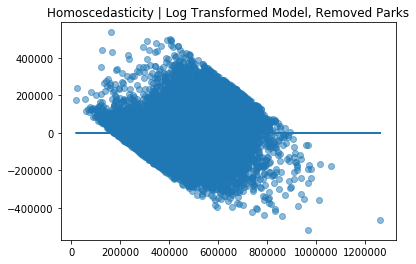

In [482]:
predictors_3 = ['sqft_living', 'log_school', 'log_coffee', 'log_scientology']

plt.scatter(model.predict(df[predictors_3]), model.resid, alpha = .5);
plt.plot(model.predict(df[predictors_3]), [0 for i in range(len(df))]);
plt.title('Homoscedasticity | Log Transformed Model, Removed Parks');

Once again, the variability of price is not equal at all; this model is heteroscedastic. And although we considered removing distance to parks, our R2 score actually dropped a bit as a result.

## Model #4  
We attempted a new model with only sqare-foot living space and school as features.

In [483]:
# trying with only sqft_living and school

features = ['sqft_living', 'log_school']
target = ['price']
X = df[features]
y = df[target]

lm4 = LinearRegression().fit(X, y)

lm4_preds = lm4.predict(X)

print('R^2: ', r2_score(y, lm4_preds))

R^2:  0.5184159812175783


In [484]:
formula = "price ~ sqft_living+log_school"
model = ols(formula= formula, data=df).fit()

In [485]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     8876.
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:37:45   Log-Likelihood:            -2.1680e+05
No. Observations:               16493   AIC:                         4.336e+05
Df Residuals:                   16490   BIC:                         4.336e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.956e+05   2782.391     70.284      0.000     1.9e+05    2.01e+05
sqft_living   149.2004      1.362    109.564      0.000     146.531     151.870
log_school  -6.475e+04    766.641    -84.462      0.000   -6.63e+04   -6.32e+04
==============================================================================
Omnibus:                      561.519   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              689.284
Skew:                           0.402   Prob(JB):                    2.11e-150
Kurtosis:                       3.598   Cond. No.                     5.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Again, the model performs worse upon removal of features.

## Model #5  

We tried another model with all features, this time using the train_test_split method to train and test our model.

In [486]:
features = ['sqft_living', 'log_school', 'log_scientology', 'log_coffee', 'log_park']
target = ['price']
X = df[features]
y = df[target]

# fifth iteration of model: with all and train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm5 = LinearRegression().fit(X_train, y_train)
lm5_preds = lm5.predict(X_test)

print('R^2: ', r2_score(y_test, lm5_preds))

R^2:  0.5793658205477772


In [487]:
y_predict = lm5.predict(X_test)

X2 = sm.add_constant(X)

# create an OLS model
model = sm.OLS(y, X2)

# fit the data
est = model.fit()

/Users/dtunnicliffe/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


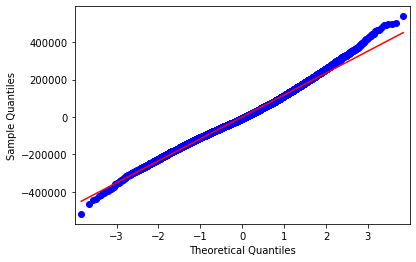

The mean of the residuals is 6.329e-10


In [488]:
# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

This is the best one so far; the R2 improves when we use all our log-transformed features and train_test_split.

## Model #6  

We checked for multicolinearity and found that there was multicolinearity between our distance to schools and distance to scientology churches. So we created an interaction column to account for this.

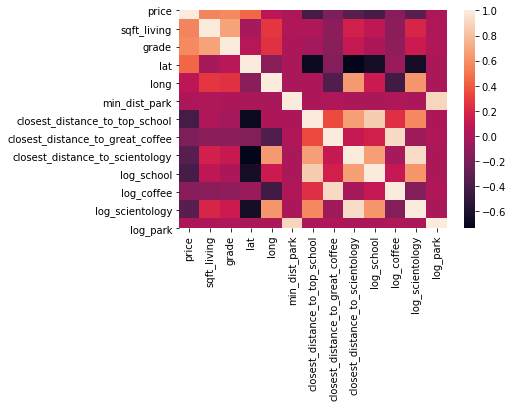

In [489]:
sns.heatmap(df.corr());

In [490]:
df.corr()

,price,sqft_living,grade,lat,long,min_dist_park,closest_distance_to_top_school,closest_distance_to_great_coffee,closest_distance_to_scientology,log_school,log_coffee,log_scientology,log_park
price,1.00,0.56,0.57,0.45,0.07,0.01,-0.42,-0.18,-0.34,-0.41,-0.14,-0.33,0.01
sqft_living,0.56,1.00,0.68,-0.02,0.27,0.01,0.02,-0.13,0.17,0.08,-0.12,0.20,0.02
grade,0.57,0.68,1.00,0.05,0.25,0.01,-0.03,-0.13,0.11,0.01,-0.11,0.13,0.02
lat,0.45,-0.02,0.05,1.00,-0.13,0.01,-0.68,-0.15,-0.73,-0.63,-0.07,-0.63,0.00
long,0.07,0.27,0.25,-0.13,1.00,-0.01,0.01,-0.37,0.63,0.13,-0.43,0.62,-0.01
min_dist_park,0.01,0.01,0.01,0.01,-0.01,1.00,0.01,0.02,-0.01,0.00,0.02,-0.00,0.90
closest_distance_to_top_school,-0.42,0.02,-0.03,-0.68,0.01,0.01,1.00,0.34,0.66,0.86,0.24,0.57,0.01
closest_distance_to_great_coffee,-0.18,-0.13,-0.13,-0.15,-0.37,0.02,0.34,1.00,0.12,0.16,0.92,-0.05,0.02
closest_distance_to_scientology,-0.34,0.17,0.11,-0.73,0.63,-0.01,0.66,0.12,1.00,0.66,-0.02,0.93,-0.00
log_school,-0.41,0.08,0.01,-0.63,0.13,0.00,0.86,0.16,0.66,1.00,0.10,0.63,0.00


In [491]:
# creating an interaction column for school and scientology
# because there is multicolinearity
df['interaction'] = df['log_school'] * df['log_scientology']

features = ['sqft_living', 'log_school', 'log_scientology', 'log_coffee', 'log_park', 'interaction']
target = ['price']

X = df[features]
y = df[target]

# running an iteration of the model with interaction column and using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm6 = LinearRegression().fit(X_train, y_train)
lm6_preds = lm6.predict(X_test)

print('R^2: ', r2_score(y_test, lm6_preds))

R^2:  0.580345794192251


In [492]:
formula = "price ~ sqft_living+log_school+log_scientology+log_coffee+log_park+interaction"
model = ols(formula= formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     3625.
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:37:46   Log-Likelihood:            -2.1589e+05
No. Observations:               16493   AIC:                         4.318e+05
Df Residuals:                   16486   BIC:                         4.319e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.125e+05   6444.968     64.005      0.000       4e+05    4.25e+05
sqft_living       157.4699      1.320    119.337      0.000     154.883     160.056
log_school      -1.943e+04   4014.391     -4.840      0.000   -2.73e+04   -1.16e+04
log_scientology -7.411e+04   1706.168    -43.437      0.000   -7.75e+04   -7.08e+04
log_coffee      -1.947e+04   1552.695    -12.538      0.000   -2.25e+04   -1.64e+04
log_park         -524.3983   1214.941     -0.432      0.666   -2905.814    1857.017
interaction     -5999.1660   1304.786     -4.598      0.000   -8556.687   -3441.645
==============================================================================
Omnibus:                      341.490   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              419.795
Skew:                           0.287   Prob(JB):                     6.96e-92
Kurtosis:                       3.530   Cond. No.                     1.50e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [493]:
y_predict = lm6.predict(X_test)

X2 = sm.add_constant(X)

# create an OLS model
model = sm.OLS(y, X2)

# fit the data
est = model.fit()

/Users/dtunnicliffe/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


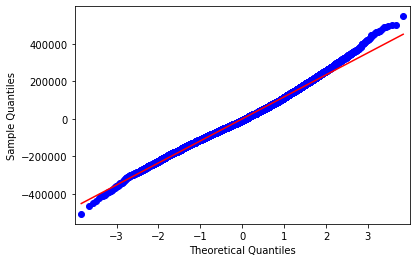

The mean of the residuals is -4.463e-08


In [494]:
# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

This is the best one so far. The model improves when we add an interaction feature. 

## Model #7  

We wanted to include 'grade' as a feature. This is a categorical variable found in the kc_housing dataset. The breakdown for the meaning of each grade designation can be found at https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r under 'Building Grade.'

In [495]:
# creating categorical dummy variables for grade
grade_dums = pd.get_dummies(df.grade, prefix='grade', drop_first=True)

In [496]:
# dropping original grade column
df = df.drop(['grade'], axis=1)
df_with_grade = pd.concat([df, grade_dums], axis=1)

In [497]:
features = ['sqft_living', 'log_coffee', 'log_park', 'interaction', 'log_school', 'log_scientology', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11']
target = ['price']
X = df_with_grade[features]
y = df_with_grade[target]

# running an iteration of the model with interaction column and using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm7 = LinearRegression().fit(X_train, y_train)
lm7_preds = lm7.predict(X_test)

print('R^2: ', r2_score(y_test, lm7_preds))

R^2:  0.6434460298499262


In [498]:
formula = "price ~ sqft_living+log_coffee+log_park+interaction+log_school+log_scientology+grade_4+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11"
model = ols(formula= formula, data=df_with_grade).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     2053.
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:37:46   Log-Likelihood:            -2.1450e+05
No. Observations:               16493   AIC:                         4.290e+05
Df Residuals:                   16478   BIC:                         4.292e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        7.271e+05   7.66e+04      9.492      0.000    5.77e+05    8.77e+05
sqft_living        98.7885      1.631     60.558      0.000      95.591     101.986
log_coffee      -1.715e+04   1430.428    -11.989      0.000      -2e+04   -1.43e+04
log_park         -747.9155   1117.323     -0.669      0.503   -2937.988    1442.158
interaction     -5651.3951   1201.494     -4.704      0.000   -8006.453   -3296.337
log_school      -1.694e+04   3694.712     -4.585      0.000   -2.42e+04   -9699.935
log_scientology -7.857e+04   1574.770    -49.893      0.000   -8.17e+04   -7.55e+04
grade_4          -2.21e+05   8.12e+04     -2.722      0.006    -3.8e+05   -6.18e+04
grade_5         -2.581e+05   7.67e+04     -3.365      0.001   -4.08e+05   -1.08e+05
grade_6         -2.793e+05   7.63e+04     -3.661      0.000   -4.29e+05    -1.3e+05
grade_7         -2.305e+05   7.62e+04     -3.024      0.002    -3.8e+05   -8.11e+04
grade_8         -1.628e+05   7.62e+04     -2.135      0.033   -3.12e+05   -1.34e+04
grade_9         -7.901e+04   7.63e+04     -1.036      0.300   -2.28e+05    7.05e+04
grade_10        -1.951e+04   7.64e+04     -0.255      0.798   -1.69e+05     1.3e+05
grade_11         1.338e+04    7.8e+04      0.171      0.864    -1.4e+05    1.66e+05
==============================================================================
Omnibus:                      727.783   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              989.161
Skew:                           0.441   Prob(JB):                    1.61e-215
Kurtosis:                       3.814   Cond. No.                     5.59e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.59e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [499]:
y_predict = lm7.predict(X_test)

X2 = sm.add_constant(X)

# create an OLS model
model = sm.OLS(y, X2)

# fit the data
est = model.fit()

/Users/dtunnicliffe/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


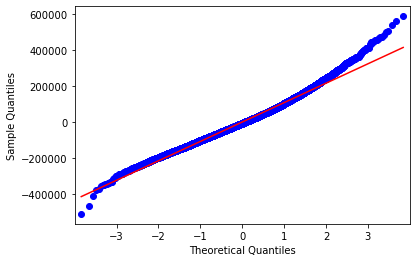

The mean of the residuals is -4.478e-08


In [500]:
# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

This has once again improved with the addition of the grade column.

## Model #8  

We then experimented with a quantile transformation of our data, as opposed to a log-transformation.

In [501]:
df = pd.read_csv('./data/all_features_quant_transformed.csv', index_col=0)
df.head()

,price,sqft_living,lat,long,min_dist_park,closest_distance_to_top_school,closest_distance_to_great_coffee,closest_distance_to_scientology,log_school,log_coffee,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,interaction
0,-1.60,-1.08,47.51,-122.26,-0.31,-1.61,-0.93,-0.24,-1.34,1.60,...,0,0,0,1,0,0,0,0,0,0.38
1,0.49,0.94,47.72,-122.32,0.92,-0.50,0.71,-0.40,-0.38,2.70,...,0,0,0,1,0,0,0,0,0,0.20
2,-2.54,-2.14,47.74,-122.23,-0.84,0.36,0.09,-0.39,0.69,2.36,...,0,0,1,0,0,0,0,0,0,-0.14
3,0.78,0.17,47.52,-122.39,-0.08,0.30,0.65,-0.33,0.55,2.67,...,0,0,0,1,0,0,0,0,0,-0.10
4,0.37,-0.22,47.62,-122.05,0.02,0.08,-0.25,0.37,0.16,2.15,...,0,0,0,0,1,0,0,0,0,0.03


In [502]:
df.drop(columns=['log_school', 'log_coffee', 'log_scientology', 'log_park'] , axis=1, inplace=True)

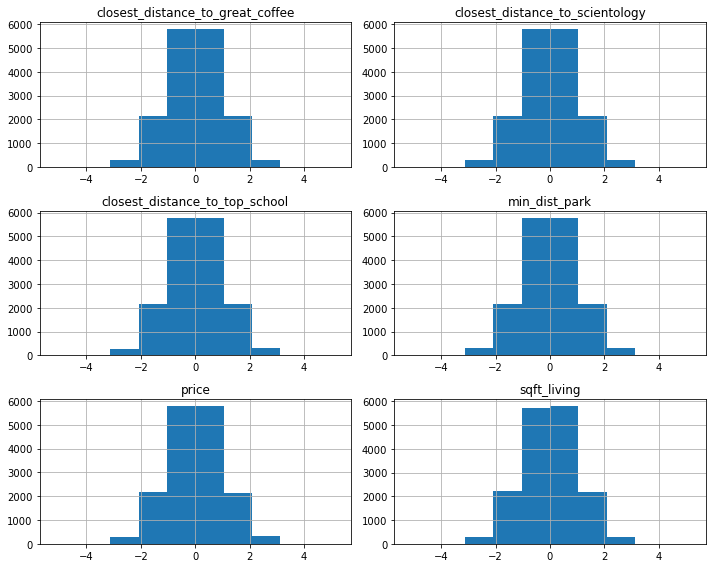

In [503]:
# checking the visual distribution of our data with histograms
df[['sqft_living', 'closest_distance_to_great_coffee', 'min_dist_park', 'closest_distance_to_top_school', 'closest_distance_to_scientology', 'price']].hist(figsize=(10,8))
plt.tight_layout();

In [504]:
features = ['sqft_living', 'closest_distance_to_great_coffee', 'min_dist_park', 'closest_distance_to_top_school', 'closest_distance_to_scientology', 'interaction', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11']
target = ['price']
X = df[features]
y = df[target]

# running an iteration of the model with quantile transformation and train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm8 = LinearRegression().fit(X_train, y_train)
lm8_preds = lm8.predict(X_test)

print('R^2: ', r2_score(y_test, lm8_preds))

R^2:  0.6308144610145117


In [505]:
formula = "price ~ sqft_living+closest_distance_to_great_coffee+min_dist_park+closest_distance_to_top_school+closest_distance_to_scientology+interaction+grade_4+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11"
model = ols(formula= formula, data=df).fit()

In [506]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     1961.
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:37:47   Log-Likelihood:                -15333.
No. Observations:               16493   AIC:                         3.070e+04
Df Residuals:                   16478   BIC:                         3.081e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.4887      0.434      3.430      0.001       0.638       2.339
sqft_living                          0.4005      0.007     60.597      0.000       0.388       0.413
closest_distance_to_great_coffee    -0.0351      0.006     -6.328      0.000      -0.046      -0.024
min_dist_park                       -0.0023      0.005     -0.474      0.636      -0.012       0.007
closest_distance_to_top_school      -0.2366      0.006    -37.579      0.000      -0.249      -0.224
closest_distance_to_scientology     -0.3240      0.006    -51.764      0.000      -0.336      -0.312
interaction                         -0.0028      0.005     -0.559      0.576      -0.013       0.007
grade_4                             -1.3811      0.462     -2.988      0.003      -2.287      -0.475
grade_5                             -1.8401      0.437     -4.215      0.000      -2.696      -0.984
grade_6                             -1.9693      0.434     -4.535      0.000      -2.821      -1.118
grade_7                             -1.6686      0.434     -3.845      0.000      -2.519      -0.818
grade_8                             -1.2934      0.434     -2.980      0.003      -2.144      -0.443
grade_9                             -0.8742      0.434     -2.013      0.044      -1.726      -0.023
grade_10                            -0.5436      0.435     -1.250      0.211      -1.396       0.309
grade_11                            -0.2912      0.444     -0.655      0.512      -1.162       0.580
==============================================================================
Omnibus:                      696.435   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2235.973
Skew:                           0.085   Prob(JB):                         0.00
Kurtosis:                       4.796   Cond. No.                         430.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [507]:
y_predict = lm8.predict(X_test)

X2 = sm.add_constant(X)

# create an OLS model
model = sm.OLS(y, X2)

# fit the data
est = model.fit()

/Users/dtunnicliffe/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


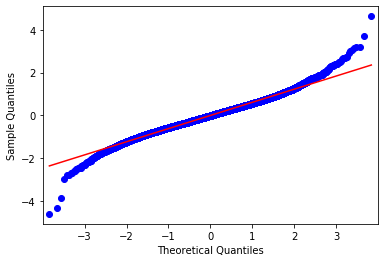

The mean of the residuals is -1.585e-15


In [508]:
# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

Our residuals are relatively normal.

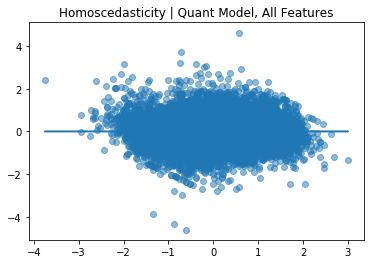

In [509]:
f = 'price ~ sqft_living+closest_distance_to_great_coffee+min_dist_park+closest_distance_to_top_school+closest_distance_to_scientology+interaction++grade_4+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11'

model = ols(formula = f, data = df).fit()
model.summary()
predictors_quant = ['sqft_living', 'closest_distance_to_great_coffee', 'min_dist_park', 'closest_distance_to_top_school', 'closest_distance_to_scientology', 'interaction', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11']

plt.scatter(model.predict(df[predictors_quant]), model.resid, alpha = .5);
plt.plot(model.predict(df[predictors_quant]), [0 for i in range(len(df))]);
plt.title('Homoscedasticity | Quant Model, All Features');

Our qq-plots, homoscedasticity, and R-squared value continue to improve with each iteration.

## Model #9  
We then experimented with a target we created, Price Per Square-Foot. While this target unfortunately decreased our R2 significantly, we were able to use this new variable we'd created as a new measurement by which to remove outliers and narrow our data further. Our last model retains our original price target, but uses data narrowed to 1.5 standard deviations from the mean of price per square foot. (For this entire process, please see previous notebook, 'data_wrangling'.) At this point, we also updated our list of parks to eliminate forests and trail heads, and only include actual parks, to make for a more accurate "distance to closest park" measurement.

In [444]:
df = pd.read_csv('./data/all_features_ppsqft_quant.csv', index_col=0)
df.head()

,price,sqft_living,lat,long,price_per_sqft,min_dist_park,closest_distance_to_top_school,closest_distance_to_great_coffee,closest_distance_to_scientology,interaction,...,quant_interaction,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,221900.00,1180,47.51,-122.26,188.05,2.04,0.26,4.39,12.71,3.33,...,-1.11,0,0,1,0,0,0,0,0,0
1,538000.00,2570,47.72,-122.32,209.34,5.67,0.68,14.81,10.80,7.37,...,-0.50,0,0,1,0,0,0,0,0,0
2,180000.00,770,47.74,-122.23,233.77,1.34,2.00,10.63,10.84,21.71,...,0.08,0,1,0,0,0,0,0,0,0
3,604000.00,1960,47.52,-122.39,308.16,2.45,1.73,14.48,11.55,19.97,...,0.05,0,0,1,0,0,0,0,0,0
4,510000.00,1680,47.62,-122.05,303.57,3.72,1.18,8.55,21.18,24.98,...,0.16,0,0,0,1,0,0,0,0,0


In [445]:
features = ['quant_sqft_living','quant_coffee', 'quant_parks', 'quant_schools', 'quant_scientology', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'quant_interaction']
target = ['quant_price']
X = df[features]
y = df[target]

# running an iteration of the model using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm9 = LinearRegression().fit(X_train, y_train)
lm9_preds = lm9.predict(X_test)

print('R^2: ', r2_score(y_test, lm9_preds))

R^2:  0.7559870492262424


In [446]:
formula = "quant_price ~ quant_sqft_living+quant_coffee+quant_parks+quant_schools+quant_scientology+quant_interaction+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+grade_12+grade_13"
model = ols(formula= formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quant_price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     3711.
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:21:37   Log-Likelihood:                -12314.
No. Observations:               17495   AIC:                         2.466e+04
Df Residuals:                   17479   BIC:                         2.479e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.7602      0.123     -6.167      0.000      -1.002      -0.519
quant_sqft_living     0.4987      0.006     89.561      0.000       0.488       0.510
quant_coffee         -0.0269      0.004     -6.792      0.000      -0.035      -0.019
quant_parks          -0.0059      0.004     -1.595      0.111      -0.013       0.001
quant_schools        -0.0690      0.021     -3.229      0.001      -0.111      -0.027
quant_scientology    -0.1565      0.014    -11.053      0.000      -0.184      -0.129
quant_interaction    -0.2132      0.031     -6.879      0.000      -0.274      -0.152
grade_5               0.1626      0.128      1.274      0.203      -0.088       0.413
grade_6               0.3070      0.123      2.492      0.013       0.066       0.549
grade_7               0.5833      0.123      4.736      0.000       0.342       0.825
grade_8               0.8820      0.124      7.131      0.000       0.640       1.124
grade_9               1.1951      0.125      9.596      0.000       0.951       1.439
grade_10              1.4316      0.126     11.387      0.000       1.185       1.678
grade_11              1.7193      0.129     13.377      0.000       1.467       1.971
grade_12              2.0848      0.144     14.463      0.000       1.802       2.367
grade_13              2.3285      0.236      9.847      0.000       1.865       2.792
==============================================================================
Omnibus:                      391.796   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              511.788
Skew:                          -0.283   Prob(JB):                    7.35e-112
Kurtosis:                       3.617   Cond. No.                         175.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [447]:
y_predict = lm9.predict(X_test)

X2 = sm.add_constant(X)

# create an OLS model
model = sm.OLS(y, X2)

# fit the data
est = model.fit()

/Users/dtunnicliffe/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


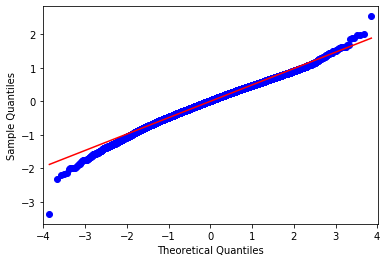

The mean of the residuals is -1.626e-15


In [448]:
# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

Our residuals are relatively normal.

### Recursive Feature Elimination (RFE)

In [449]:
# def lin_reg(X, y):
    """Recursive feature elimination (RFE) function"""
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
#     linreg = LinearRegression()
#     linreg.fit(X_train,y_train)
#     y_hat = linreg.predict(X_test)
#     y_hat_train = linreg.predict(X_train)
#     print('R_squared:', linreg.score(X, y))
#     #Display errors
#     print('Mean Absolute Error:', mean_absolute_error(y_test, y_hat))
#     print('Root Mean Squared Error test:', np.sqrt(mean_squared_error(y_test, y_hat)))
#     print('Root Mean Squared Error train:', np.sqrt(mean_squared_error(y_train, y_hat_train)))
#     #Compare predicted and actual values
#     print('Mean Predicted Selling Price:', y_hat.mean())
#     print('Mean Selling Price:', y_test.mean())
#     return linreg

In [450]:
# lin_reg(X,y)

In [451]:
#RFE to check for insignificant features 
# from sklearn.svm import SVR
# from sklearn.feature_selection import RFE

# estimator = SVR(kernel="linear")

# selector = RFE(estimator, step=1)
# selector = selector.fit(X, y)

# #Take a look at the R2 with only the most valuable features
# X_RFE = X[X.columns[selector.support_]]
# lin_reg(X_RFE, y)

## Model #10  
We then took our previous model and removed parks as a feature altogether, since further analysis showed that this was not helping our R2 score. For the entire investigation into each feature's impact on the model, please see the notebook titled 'Iterating Through Final Model."

In [459]:
features = ['quant_sqft_living','quant_coffee', 'quant_schools', 'quant_scientology', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'quant_interaction']
target = ['quant_price']
X = df[features]
y = df[target]

# running an iteration of the model using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm10 = LinearRegression().fit(X_train, y_train)
lm10_preds = lm10.predict(X_test)

print('R^2: ', r2_score(y_test, lm10_preds))

R^2:  0.7559686827061596


In [460]:
formula = "quant_price ~ quant_sqft_living+quant_coffee+quant_schools+quant_scientology+quant_interaction+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+grade_12+grade_13"
model = ols(formula= formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quant_price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     3975.
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:32:56   Log-Likelihood:                -12316.
No. Observations:               17495   AIC:                         2.466e+04
Df Residuals:                   17480   BIC:                         2.478e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.7595      0.123     -6.162      0.000      -1.001      -0.518
quant_sqft_living     0.4986      0.006     89.550      0.000       0.488       0.510
quant_coffee         -0.0268      0.004     -6.779      0.000      -0.035      -0.019
quant_schools        -0.0690      0.021     -3.229      0.001      -0.111      -0.027
quant_scientology    -0.1564      0.014    -11.045      0.000      -0.184      -0.129
quant_interaction    -0.2133      0.031     -6.882      0.000      -0.274      -0.153
grade_5               0.1622      0.128      1.271      0.204      -0.088       0.412
grade_6               0.3062      0.123      2.486      0.013       0.065       0.548
grade_7               0.5827      0.123      4.730      0.000       0.341       0.824
grade_8               0.8813      0.124      7.125      0.000       0.639       1.124
grade_9               1.1946      0.125      9.592      0.000       0.951       1.439
grade_10              1.4313      0.126     11.385      0.000       1.185       1.678
grade_11              1.7186      0.129     13.371      0.000       1.467       1.971
grade_12              2.0842      0.144     14.458      0.000       1.802       2.367
grade_13              2.3268      0.236      9.839      0.000       1.863       2.790
==============================================================================
Omnibus:                      391.327   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              510.627
Skew:                          -0.283   Prob(JB):                    1.31e-111
Kurtosis:                       3.616   Cond. No.                         175.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [461]:
y_predict = lm10.predict(X_test)

X2 = sm.add_constant(X)

# create an OLS model
model = sm.OLS(y, X2)

# fit the data
est = model.fit()

/Users/dtunnicliffe/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


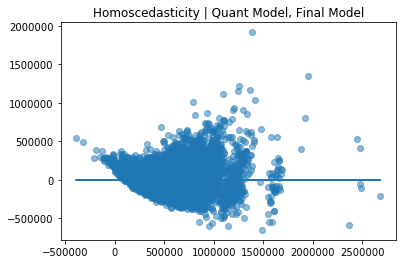

In [466]:
f = 'price ~ quant_sqft_living+quant_coffee+quant_schools+quant_scientology+quant_interaction+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+grade_12+grade_13'
model = ols(formula = f, data = df).fit()

predictors_quant = ['quant_sqft_living','quant_coffee', 'quant_schools', 'quant_scientology', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'quant_interaction']

plt.scatter(model.predict(df[predictors_quant]), model.resid, alpha = .5);
plt.plot(model.predict(df[predictors_quant]), [0 for i in range(len(df))]);
plt.title('Homoscedasticity | Quant Model, Final Model');

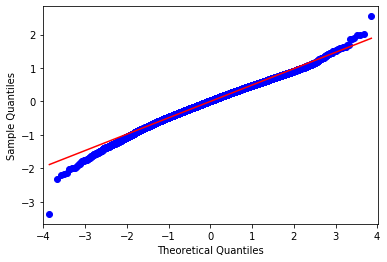

The mean of the residuals is -7.203e-16


In [462]:
# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

## Model #10  
We then took our previous model and removed certain grades as features, as they were not helping our model and possibly creating heteroscedasticity.

In [510]:
features = ['quant_sqft_living','quant_coffee', 'quant_schools', 'quant_scientology', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'quant_interaction']
target = ['quant_price']
X = df[features]
y = df[target]

# running an iteration of the model using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lm11 = LinearRegression().fit(X_train, y_train)
lm11_preds = lm11.predict(X_test)

print('R^2: ', r2_score(y_test, lm11_preds))

KeyError: "['quant_interaction', 'grade_13', 'quant_schools', 'quant_sqft_living', 'quant_scientology', 'quant_coffee'] not in index"

In [460]:
formula = "quant_price ~ quant_sqft_living+quant_coffee+quant_schools+quant_scientology+quant_interaction+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+grade_12+grade_13"
model = ols(formula= formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quant_price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     3975.
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:32:56   Log-Likelihood:                -12316.
No. Observations:               17495   AIC:                         2.466e+04
Df Residuals:                   17480   BIC:                         2.478e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.7595      0.123     -6.162      0.000      -1.001      -0.518
quant_sqft_living     0.4986      0.006     89.550      0.000       0.488       0.510
quant_coffee         -0.0268      0.004     -6.779      0.000      -0.035      -0.019
quant_schools        -0.0690      0.021     -3.229      0.001      -0.111      -0.027
quant_scientology    -0.1564      0.014    -11.045      0.000      -0.184      -0.129
quant_interaction    -0.2133      0.031     -6.882      0.000      -0.274      -0.153
grade_5               0.1622      0.128      1.271      0.204      -0.088       0.412
grade_6               0.3062      0.123      2.486      0.013       0.065       0.548
grade_7               0.5827      0.123      4.730      0.000       0.341       0.824
grade_8               0.8813      0.124      7.125      0.000       0.639       1.124
grade_9               1.1946      0.125      9.592      0.000       0.951       1.439
grade_10              1.4313      0.126     11.385      0.000       1.185       1.678
grade_11              1.7186      0.129     13.371      0.000       1.467       1.971
grade_12              2.0842      0.144     14.458      0.000       1.802       2.367
grade_13              2.3268      0.236      9.839      0.000       1.863       2.790
==============================================================================
Omnibus:                      391.327   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              510.627
Skew:                          -0.283   Prob(JB):                    1.31e-111
Kurtosis:                       3.616   Cond. No.                         175.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [461]:
y_predict = lm10.predict(X_test)

X2 = sm.add_constant(X)

# create an OLS model
model = sm.OLS(y, X2)

# fit the data
est = model.fit()

/Users/dtunnicliffe/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


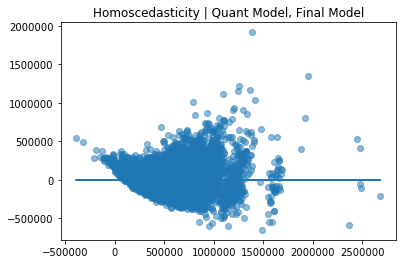

In [466]:
f = 'price ~ quant_sqft_living+quant_coffee+quant_schools+quant_scientology+quant_interaction+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+grade_12+grade_13'
model = ols(formula = f, data = df).fit()

predictors_quant = ['quant_sqft_living','quant_coffee', 'quant_schools', 'quant_scientology', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'quant_interaction']

plt.scatter(model.predict(df[predictors_quant]), model.resid, alpha = .5);
plt.plot(model.predict(df[predictors_quant]), [0 for i in range(len(df))]);
plt.title('Homoscedasticity | Quant Model, Final Model');

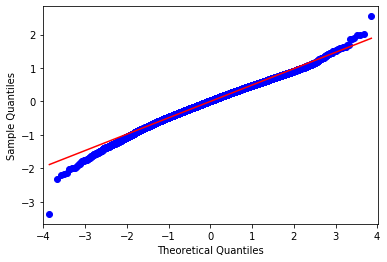

The mean of the residuals is -7.203e-16


In [462]:
# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

Our residuals are relatively normal.

Our homoscedasticity declines with this final iteration; however, our R-squared, p-values, Durbin-Watson, and prob(F-statistic) are better than they were previously.

### Results

The results of our complete analysis were as follows:
* The feature with the highest impact on our R-squared value was square-footage of living space, which was positively correlated with house prices.
* The feature with the next-highest impact was distance to a top school, which was negatively correlated with house prices. 
* The feature with the next-highest impact was building grade, which was positively correlated with house prices.  
* The feature with the next-highest impact was distance to a scientology church, which was negatively correlated with house prices.
* The feature with the next-highest impact was distance to a great coffee shop, which was negatively correlated with house prices.
* The interaction between distance to a top school and distance to a scientology church was significant, as there was multicolinearity between the two. Accounting for this interaction showed improvement to our model.
* And finally, the feature with the least impact was distance to a park, which had no significant impact on our model.

We are confident that the results we extrapolated from this analysis would generalize beyond the data that we have. By looking at the available data, the trends and correlations we found were true for houses built from 1900 to 2015, so we are confident that they would hold true for houses built today. Despite the global pandemic, people are still buying and selling their homes. We have seen that children are still largely attending schools, and we speculate that people continue to desire a well-built homes with a large amount of living space, now more than ever. And the data has shown that people tend to pay more for a home that's near a good coffee shop and a scientology church!

If the recommendations that we made are put to use, we are confident that King County Developers will have a successful career in the housing market. From the data, it is clear that all the attributes we have discussed are correlated with high home sale prices, which is exactly what King County Developers will want for their projects.


### Final Evaluation and Conclusion

Our best model had an R-squared value of 0.761, telling us that the model fit the data with an accuracy of 76%. After reviewing this final iteration, we felt confident in our recommendations that all of our available features except parks be considered by home developers in order to increase selling price. Sqare-feet of living space, building grade, distance to great schools, coffee shops, and churches of scientology, as well as the interaction between schools and scientology churches, all play a valuable role in predicting the price of a house in King County.

The prob(F-statistic) of 0.00 tells us that there is an extremely low probability of achieving these results with the null hypothesis being true, and tells us that our regression is meaningful. Our p-values for our features are well below our alpha or significance level, showing that they are each contributing to the model significantly. With an alpha of 0.05, at a confidence level of 95%, we reject the null hypothesis that there is no relationship between our features and our target variable, price.

Our recommendations are as follows:
* increase square-footage of living space
* attain the highest possible building grade
* build and develop homes in close proximity to a top school district
* build and develop homes in close proximity to a highly-rated coffee shop
* build and develop homes in close proximity to a scientology church

By following the above recommendations, a housing development company in King County can increase their chances of selling higher-priced homes.

In the future, our next steps would be reducing noise in the data to improve the accuracy of our model. Additionally, we would like to investigate certain features, such as constructional/architectural values of the house, to see what trends we could discern from that. Some ideas would be whether basements are correlated with higher house prices, or whether the amount of bathrooms has an impact. 